# Loading packages and data
---

In [3]:
#Installing required packages

!pip install kmodes gower pandas numpy scikit-learn matplotlib seaborn


In [27]:
#Load dataset

import pandas as pd

df = pd.read_csv('synthetic_evaluation_data.csv')



# Prepare data:


First I will inspect my data and see if there are any missing values.

In [26]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   participant_id    30 non-null     int64  
 1   state_1           30 non-null     object 
 2   state_2           30 non-null     object 
 3   state_3           30 non-null     object 
 4   state_4           30 non-null     object 
 5   choice_1          30 non-null     object 
 6   choice_2          30 non-null     object 
 7   choice_3          30 non-null     object 
 8   choice_4          30 non-null     object 
 9   EDA               30 non-null     float64
 10  PerceivedArousal  30 non-null     int64  
 11  Valence           30 non-null     int64  
 12  Agency            30 non-null     int64  
 13  Identification    30 non-null     float64
 14  Immersion         30 non-null     float64
 15  SystemQ1          30 non-null     int64  
 16  SystemQ2          30 non-null     int64  
 17 

In [5]:
from sklearn.preprocessing import MinMaxScaler

#Dropping unrealevant columns like ID, states and choices
df_model = df.drop(columns=['participant_id']
                   + list(df.filter(regex='state|choice').columns))


# Separate categorical and numerical columns
categorical_cols = [c for c in df_model.columns if df_model[c].dtype == 'object']
numerical_cols   = [c for c in df_model.columns if c not in categorical_cols]

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)

# Scale numerical features to [0,1]
scaler = MinMaxScaler()
df_scaled = df_model.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

# Create numpy matrix for K-Prototypes
X = df_scaled.to_numpy()

# Indices of categorical columns in X
cat_idx = [df_scaled.columns.get_loc(c) for c in categorical_cols]
cat_idx




Categorical: ['final_category']
Numerical: ['EDA', 'PerceivedArousal', 'Valence', 'Agency', 'Identification', 'Immersion', 'SystemQ1', 'SystemQ2']


[8]

# Finding optimal k

## Run K-Prototypes for several k values
---

We try multiple k and store models, costs and labels.

In [13]:
import numpy as np
from kmodes.kprototypes import KPrototypes

models = {}
costs = {}
cluster_labels = {}

K_range = range(2, 6)

for k in K_range:
    print(f"Fitting K-Prototypes with k={k}...")
    kp = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=10,
        random_state=42
    )

    labels = kp.fit_predict(X, categorical=cat_idx)

    models[k] = kp                 #save the trained model
    costs[k] = kp.cost_
    cluster_labels[k] = labels




Fitting K-Prototypes with k=2...
Fitting K-Prototypes with k=3...
Fitting K-Prototypes with k=4...
Fitting K-Prototypes with k=5...


## Compute silhouette scores with Gower distance

In [14]:
import gower
from sklearn.metrics import silhouette_score

df_mixed = df_scaled.copy()

# Precompute Gower distance matrix once
gower_dist = gower.gower_matrix(df_mixed)

sil_scores = {}

for k in K_range:
    labels = cluster_labels[k]
    sil = silhouette_score(gower_dist, labels, metric="precomputed")
    sil_scores[k] = sil

sil_scores


{2: np.float32(0.24124517),
 3: np.float32(0.15540963),
 4: np.float32(0.13298157),
 5: np.float32(0.10384112)}

### Results table and plots for better overwiev

In [15]:
results_df = pd.DataFrame({
    'k': list(K_range),
    'cost': [costs[k] for k in K_range],
    'silhouette': [sil_scores[k] for k in K_range]
})

results_df


,k,cost,silhouette
0,2,13.151852,0.241245
1,3,11.463675,0.155410
2,4,10.077111,0.132982
3,5,9.464656,0.103841


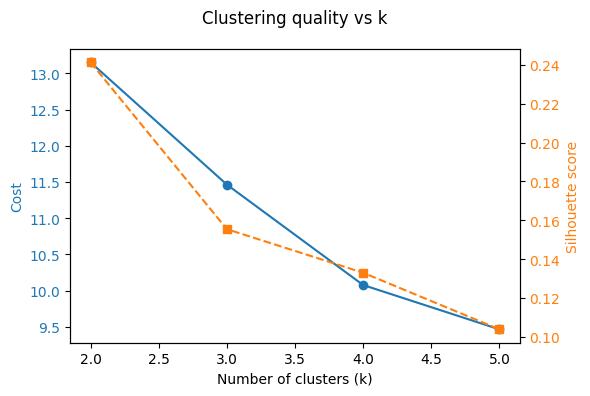

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(results_df['k'], results_df['cost'], marker='o', label='Cost')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Cost', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(results_df['k'], results_df['silhouette'], marker='s', linestyle='--',
         label='Silhouette', color='tab:orange')
ax2.set_ylabel('Silhouette score', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.suptitle('Clustering quality vs k')
fig.tight_layout()
plt.show()


# Fit model with chosen k and analyse clusters

In [23]:
k_best = 2

kp_final = models[k_best]
labels_final = cluster_labels[k_best]

# Attach clusters to original (unscaled) data
df_clusters = df_model.copy()
df_clusters['cluster'] = labels_final

# Cluster sizes
print("Cluster sizes:")
print(df_clusters['cluster'].value_counts(), "\n")

# Numerical feature means per cluster
print("Numerical means per cluster:")
print(df_clusters.groupby('cluster')[numerical_cols].mean(), "\n")

# Categorical distributions per cluster
print("Categorical distributions per cluster (proportions):")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df_clusters.groupby('cluster')[col].value_counts(normalize=True))


Cluster sizes:
cluster
0    18
1    12
Name: count, dtype: int64 

Numerical means per cluster:
              EDA  PerceivedArousal   Valence    Agency  Identification  \
cluster                                                                   
0        2.914722          3.444444  5.166667  4.444444       72.561111   
1        4.240417          5.333333  4.333333  3.500000       73.491667   

         Immersion  SystemQ1  SystemQ2  
cluster                                 
0        79.933333  4.611111  4.611111  
1        67.425000  4.333333  4.250000   

Categorical distributions per cluster (proportions):

final_category:
cluster  final_category        
0        non-stressed_mixed        0.388889
         non-stressed_honest       0.166667
         mixed_defensive           0.111111
         mixed_honest              0.111111
         mixed_mixed               0.111111
         non-stressed_defensive    0.111111
1        stressed_mixed            0.333333
         mixed_defensive   

## Visualize clusters

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


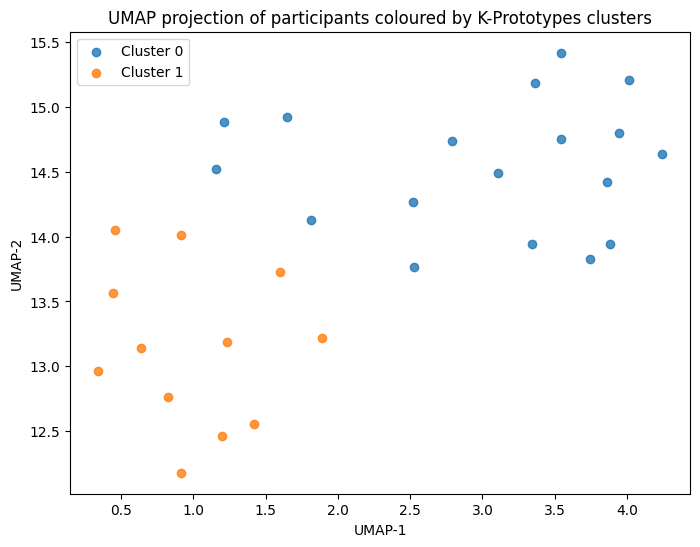

In [24]:
!pip install umap-learn gower

import gower
import umap.umap_ as umap
import matplotlib.pyplot as plt

# computing Gower distance on the modelling data (scaled numericals + categoricals, no ID)
#    If you used a different dataframe name, adjust here.
df_mixed = df_scaled.copy()
gower_dist = gower.gower_matrix(df_mixed)

#UMAP on the precomputed Gower distance matrix
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    metric='precomputed',
    random_state=42
)
embedding = reducer.fit_transform(gower_dist)   # shape (n_samples, 2)

#plot UMAP embedding, coloured by cluster
plt.figure(figsize=(8, 6))

for cl in sorted(df_clusters['cluster'].unique()):
    idx = df_clusters['cluster'] == cl
    plt.scatter(
        embedding[idx, 0],
        embedding[idx, 1],
        label=f'Cluster {cl}',
        alpha=0.8
    )

plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title('UMAP projection of participants coloured by K-Prototypes clusters')
plt.legend()
plt.show()


# Stability analysis to see how sensitive clusters are to random initialization

In [25]:
from sklearn.metrics import adjusted_rand_score

def run_kprototypes(k, random_state):
    kp = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=1,
        random_state=random_state
    )
    labels = kp.fit_predict(X, categorical=cat_idx)
    return labels

k = k_best
base_labels = run_kprototypes(k, 0)

aris = []
for rs in range(1, 20):
    labels_rs = run_kprototypes(k, rs)
    ari = adjusted_rand_score(base_labels, labels_rs)
    aris.append(ari)

aris, np.mean(aris)


([0.8666307209235942,
  0.8666307209235942,
  0.8666814622237722,
  -0.020508900990414317,
  1.0,
  0.8666814622237722,
  1.0,
  0.8666814622237722,
  0.8666814622237722,
  1.0,
  0.8666814622237722,
  0.8666814622237722,
  0.8666814622237722,
  0.8666814622237722,
  0.8666307209235942,
  0.8666307209235942,
  0.8666307209235942,
  0.8666307209235942,
  0.8666814622237722],
 np.float64(0.8410215044507946))